# Coursera Reviews EDA
- Explore the course metadata and explore relationships between features with rating as the target
- Identify potentially interesting features to pair with sentiment
- Explore word distributions, keywords, etc in reviews.

In [1]:
!pip -q install datasets transformers huggingface_hub langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 18.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import scipy.stats as stats
import re
import nltk
from nltk.corpus import words
from collections import Counter
import math
import unicodedata
import time
from tqdm import tqdm
import pickle
from langdetect import detect
import warnings

In [3]:
nltk.download('words')

[nltk_data] Downloading package words to /usr/share/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [4]:
courses_df = pd.read_csv('/kaggle/input/course-reviews-on-coursera/Coursera_courses.csv')
courses_df.head(3)

,name,institution,course_url,course_id
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning
1,Indigenous Canada,University of Alberta,https://www.coursera.org/learn/indigenous-canada,indigenous-canada
2,The Science of Well-Being,Yale University,https://www.coursera.org/learn/the-science-of-...,the-science-of-well-being


In [5]:
reviews_df = pd.read_csv('/kaggle/input/course-reviews-on-coursera/Coursera_reviews.csv')
reviews_df.head(3)

,reviews,reviewers,date_reviews,rating,course_id
0,"Pretty dry, but I was able to pass with just t...",By Robert S,"Feb 12, 2020",4,google-cbrs-cpi-training
1,would be a better experience if the video and ...,By Gabriel E R,"Sep 28, 2020",4,google-cbrs-cpi-training
2,Information was perfect! The program itself wa...,By Jacob D,"Apr 08, 2020",4,google-cbrs-cpi-training


In [6]:
print(reviews_df.sample(n=5).reviews.values)

['outstanding opportunity to learn advance techniques in this COVID-19 situation'
 'The instructors are very experienced and knowledgeable. The pace of the course is awesome that provides time for absorbing things. It deals with each aspect that an individual comes across while going for a job interview. I personally feel it was the right decision to invest time in this course. Lots of respects and thanks to Coursera, the Instructors, and The University of Pennsylvania.'
 'Amazing instructors, very appreciate their input and explanations by typing it on the system.  Very well thought and excellent material content. '
 '아주 기본적이면서도 쉽게 놓칠수 있는 부분에 있어 채워나갈 수 있는 강의였습니다.'
 'Not only very well taught by Andrew Ng sir, this course develops a good foundation on machine learning with the insight and applications of taught topics in the present day Information industry.']


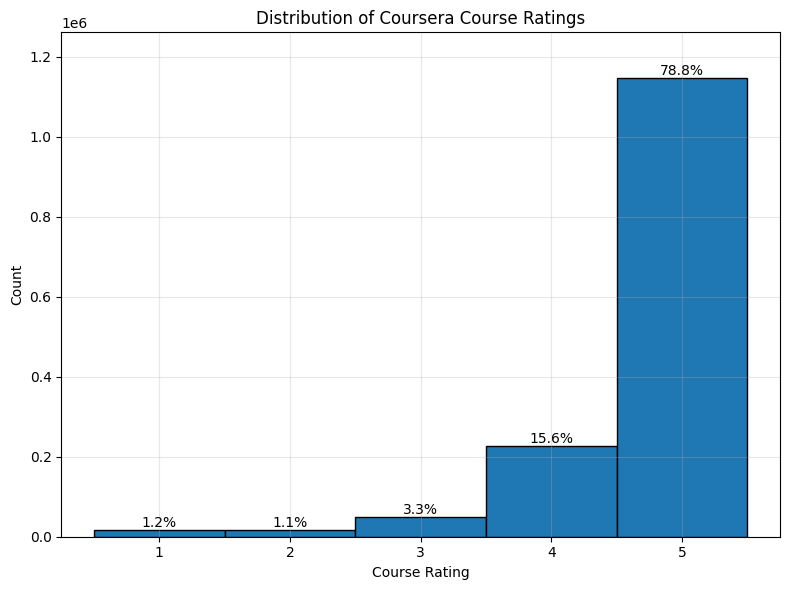

In [7]:
plt.figure(figsize=(8,6))

counts, bins, patches = plt.hist(reviews_df['rating'], 
                                 bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5],
                                 edgecolor='black')
    
plt.xticks([1, 2, 3, 4, 5])

for count, x in zip(counts, [1, 2, 3, 4, 5]):
    plt.text(x, count, f'{int(count)/len(reviews_df):.1%}', ha='center', va='bottom')
    
plt.xlabel('Course Rating')
plt.ylabel('Count')
plt.title('Distribution of Coursera Course Ratings')
plt.grid(True, alpha=0.3)

# Ensure y-axis starts at 0 and has some padding on top
plt.margins(y=0.1)
plt.tight_layout()
plt.savefig('rating_hist.png')
# Display the plot
plt.show()

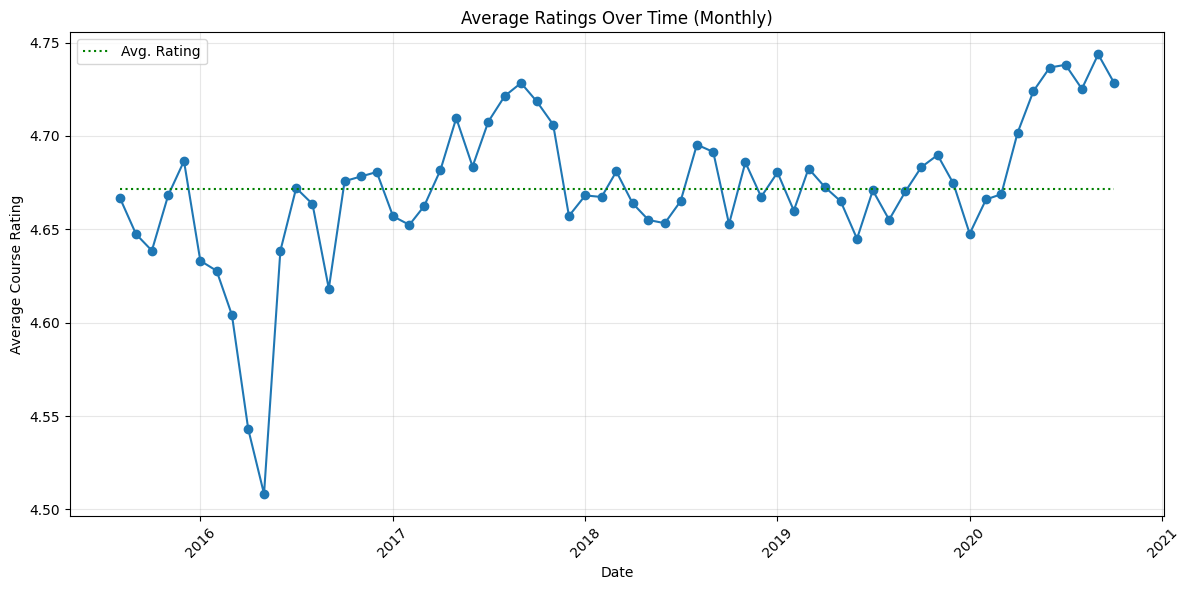

In [8]:
def plot_monthly_avg(df, dates, ratings):
    # Plot average ratings over time
    reviews_df[dates] = pd.to_datetime(reviews_df[dates])
    
    reviews_df['year_month'] = reviews_df[dates].dt.to_period('M')
    monthly_avg = reviews_df.groupby('year_month')[ratings].mean().reset_index()
    monthly_avg['year_month'] = monthly_avg['year_month'].dt.to_timestamp()
    
    # Plot the monthly average
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_avg['year_month'], monthly_avg['rating'], 
             marker='o', linestyle='-', linewidth=1.5)
    
    # Plot overall average
    plt.hlines(y=monthly_avg[ratings].mean(), 
               xmin=monthly_avg['year_month'].min(), 
               xmax=monthly_avg['year_month'].max(), 
               colors='g', linestyles='dotted', label='Avg. Rating')
    
    plt.xlabel('Date')
    plt.ylabel('Average Course Rating')
    plt.title('Average Ratings Over Time (Monthly)')
    plt.grid(True, alpha=0.3)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    plt.legend()
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.savefig('rating_over_time.png')
    # Show the plot
    plt.show()

plot_monthly_avg(reviews_df, 'date_reviews', 'rating')

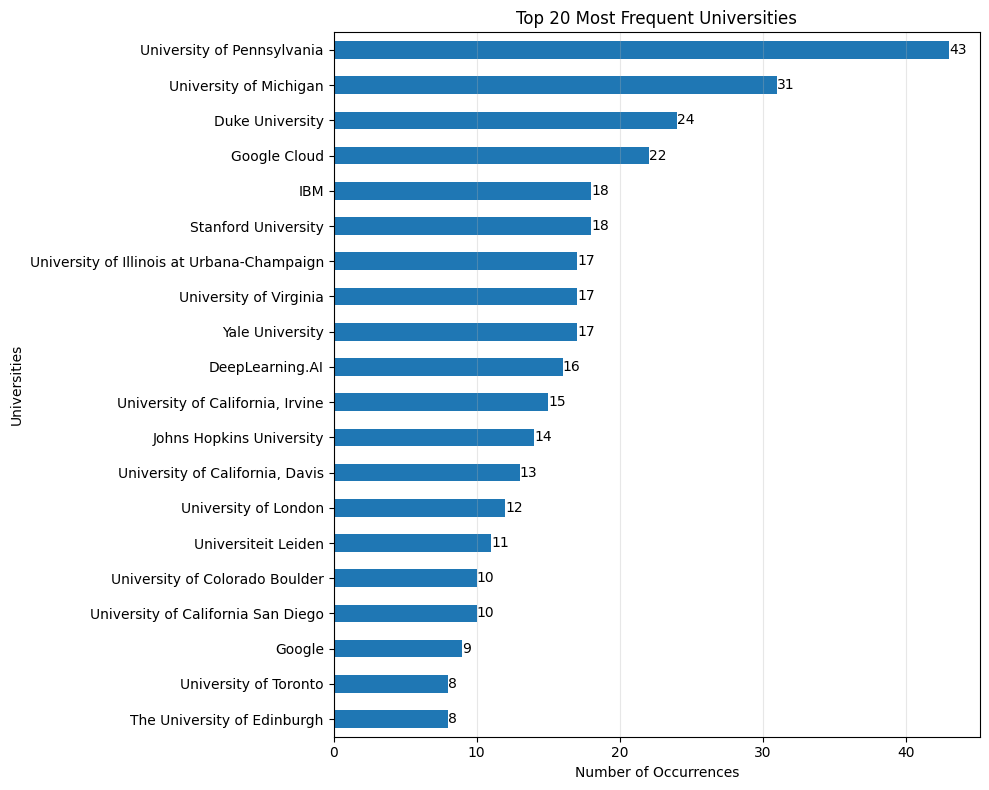

In [9]:
def plot_top_categories(df, column_name, n=20):

    uni_counts = df[column_name].value_counts().head(n)
    
    # Create horizontal bar chart
    plt.figure(figsize=(10, 8))
    uni_counts.plot(kind='barh')
    
    plt.xlabel('Number of Occurrences')
    plt.ylabel('Universities')
    plt.title(f'Top {n} Most Frequent Universities')
    plt.grid(True, alpha=0.3, axis='x')
    
    # Invert y-axis to have highest count at top
    plt.gca().invert_yaxis()
    
    # Add counts on the bars
    for i, v in enumerate(uni_counts):
        plt.text(v, i, str(v), va='center')
    
    # Adjust layout
    plt.tight_layout()
    plt.savefig('top_universities.png')
    plt.show()

plot_top_categories(courses_df, 'institution')

#### Merge the dataframes

In [10]:
merged_df = pd.merge(courses_df, reviews_df, 
                    on='course_id', 
                    how='inner')  # 'inner' keeps only matching records

In [11]:
# Calculate average ratings per university and counts for each
avg_ratings = merged_df.groupby('institution')['rating'].mean()
rating_counts = merged_df.groupby('institution')['rating'].count()

uni_stats = pd.DataFrame({
    'avg_rating': avg_ratings,
    'n_ratings': rating_counts
})

# Find outliers with IQR
Q1 = uni_stats['avg_rating'].quantile(0.25)
Q3 = uni_stats['avg_rating'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = uni_stats[(uni_stats['avg_rating'] < lower_bound) | 
                    (uni_stats['avg_rating'] > upper_bound)].reset_index()

def get_hi_low(row, hi, low):
    if row['avg_rating'] > hi:
        return 'High'
    elif row['avg_rating'] < low:
        return 'Low'
    else:
        return "Normal"

outliers['hi_lo'] = outliers.apply(lambda row: get_hi_low(row, upper_bound, lower_bound), axis=1)

print("Potential Outliers (using IQR method):")
if not outliers.empty:
    #print(outliers)
    # Construct Markdown table manually
    md_table = f"| {'Institution'} | Average Rating | Number of Ratings |\n"
    md_table += "|------------|----------------|-------------------|\n"
    for _, row in outliers.iterrows():
        md_table += f"| {row['institution']} | {row['avg_rating']:.2f} | {row['n_ratings']} | {row['hi_lo']} |\n"
    md_table += f"| **Overall Avg** | **{uni_stats['avg_rating'].mean():.2f}** | **{len(merged_df)}** | N/A |\n"
    print(md_table)
else:
    print("No outliers detected.")

Potential Outliers (using IQR method):
| Institution | Average Rating | Number of Ratings |
|------------|----------------|-------------------|
| Advancing Women in Product | 4.33 | 9 | Low |
| ESCP Business School | 4.31 | 153 | Low |
| IE Business School | 4.01 | 82 | Low |
| LearnQuest | 4.32 | 246 | Low |
| New York Institute of Finance | 3.40 | 368 | Low |
| Novosibirsk State University  | 4.03 | 195 | Low |
| Saint Petersburg State University | 3.33 | 204 | Low |
| University of New Mexico | 1.00 | 6 | Low |
| Yandex | 3.42 | 290 | Low |
| **Overall Avg** | **4.65** | **1454711** | N/A |



Potential Average Rating Outliers (using IQR method):
| Institution | Average Rating | Number of Ratings | High/Low |
|------------|----------------|-------------------| ------- |
| Advancing Women in Product | 4.33 | 9 | Low |
| ESCP Business School | 4.31 | 153 | Low |
| IE Business School | 4.01 | 82 | Low |
| LearnQuest | 4.32 | 246 | Low |
| New York Institute of Finance | 3.40 | 368 | Low |
| Novosibirsk State University  | 4.03 | 195 | Low |
| Saint Petersburg State University | 3.33 | 204 | Low |
| University of New Mexico | 1.00 | 6 | Low |
| Yandex | 3.42 | 290 | Low |
| **Overall Avg** | **4.65** | **1454711** | N/A |

#### Cleaning the Reviews - Word Counts + Entropy

In [12]:
# Find entries with no review
print(f"There are {sum(merged_df.reviews.isna())} entries with no review text")

There are 153 entries with no review text


In [13]:
df = merged_df.dropna(subset=['reviews'])
print(f"Dropped {len(merged_df) - len(df)} entries with no reviews")

Dropped 153 entries with no reviews


In [14]:
#df = df[df['reviews'].str.len() < 10]

print(f"There are {len(df[df['reviews'].str.len() < 5])} entries with < 5 characters")
print(f"There are {len(df[df['reviews'].str.len() < 10])} entries with < 10 characters")

There are 29031 entries with < 5 characters
There are 78044 entries with < 10 characters


We notice that a lot of the remaining non null entries have very short reviews. Let's look at some of the entries where there are less than 4 characters. I picked 4 since the word "good" comes up quite frequently.

In [15]:
df[df['reviews'].str.len() < 4].head(10).reviews

7347    das
7372    das
7397    das
7398     no
7399     E>
7400     OK
7401      T
7402      g
7403      .
7404      G
Name: reviews, dtype: object

If we limit it to 10 characters, we see reviews like "its good" or "good" so this seems like a reasonable limit. There may still be entries with nonsensical words.

In [16]:
df[df['reviews'].str.len() < 10].head(8).reviews

318         jhkd
331         jhkd
344         jhkd
916    very good
917     Good..!!
918     its good
941    very good
942     Good..!!
Name: reviews, dtype: object


Review Word Count Stats:
|       |     word_count |
|:------|---------------:|
| count |    1.45456e+06 |
| mean  |   22.3954      |
| std   |   27.5751      |
| min   |    0           |
| 25%   |    6           |
| 50%   |   14           |
| 75%   |   29           |
| max   | 1359           |


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


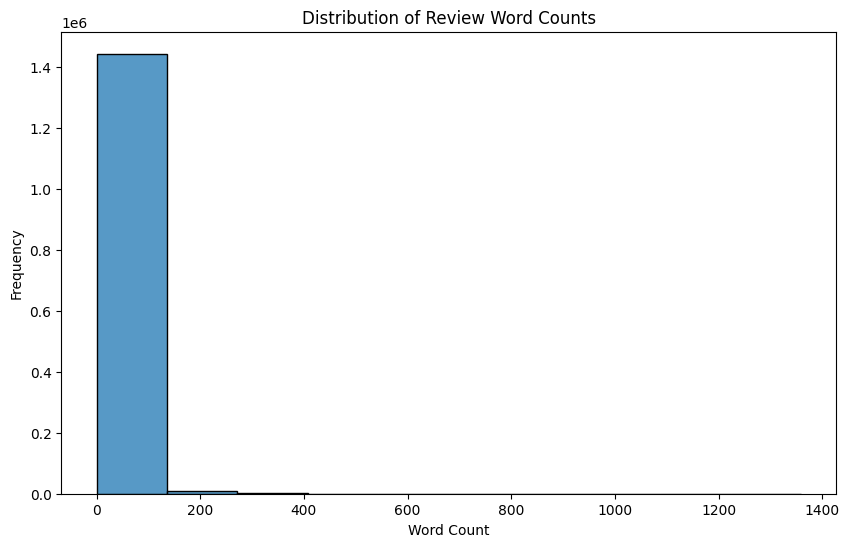

In [17]:
# Review length (word count)
word_count_df = df.copy()
word_count_df['word_count'] = word_count_df['reviews'].apply(lambda x: len(str(x).split()))
print("\nReview Word Count Stats:")
print(word_count_df['word_count'].describe().to_markdown())

plt.figure(figsize=(10, 6))
sns.histplot(word_count_df['word_count'], bins=10)
plt.title('Distribution of Review Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

This plot is not very meaningful, need to cut the outliers to get better idea


97.5th Percentile Cutoff: 91 words


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


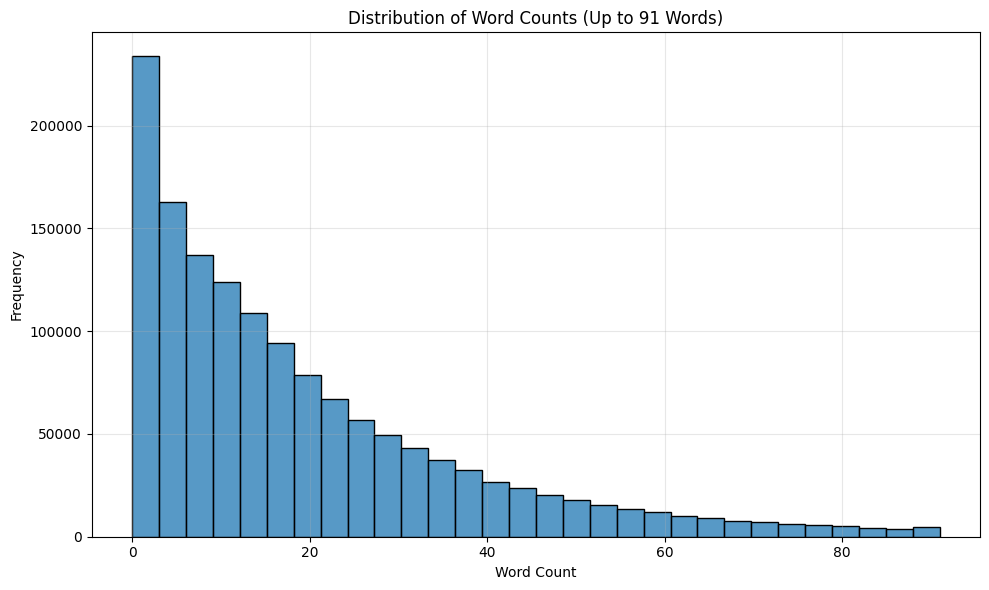


Sample of Outlier Reviews:
| Review Text | Word Count |
|-------------|------------|
| This is an extremely basic course. Machine lear... | 152 |
| I just started week 3 , I have to admit that It... | 93 |
| This course is absolute garbage.  You get no fe... | 107 |
| Have to give a star so I will give it one.  Oth... | 131 |
| I would rename this course as Programming Octav... | 125 |



In [18]:
def plot_word_count_distribution(original_df, review_col='reviews', percentile_cutoff=95, sample_size=5):

    df = original_df.copy()
    df['word_count'] = df[review_col].apply(lambda x: len(str(x).split()))

    # Set word count cutoff to a given percentile. Defult to 95
    cutoff = np.percentile(df['word_count'], percentile_cutoff)
    print(f"\n{percentile_cutoff}th Percentile Cutoff: {cutoff:.0f} words")

    main_range = df['word_count'][df['word_count'] <= cutoff]
    outliers = df[df['word_count'] > cutoff]
    
    # Plot histogram for main range
    plt.figure(figsize=(10, 6))
    sns.histplot(main_range, bins=30)
    plt.title(f'Distribution of Word Counts (Up to {cutoff:.0f} Words)')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('word_count_hist.png')
    plt.show()

    # Make output df of outliers and print to markdown
    if not outliers.empty:
        
        outlier_sample = outliers[[review_col, 'word_count']].head(sample_size)
        
        md_table = "| Review Text | Word Count |\n"
        md_table += "|-------------|------------|\n"
        for _, row in outlier_sample.iterrows():
            # Truncate long text for display (optional)
            text = row[review_col] if len(row[review_col]) < 50 else row[review_col][:47] + "..."
            md_table += f"| {text} | {row['word_count']} |\n"
        
        print("\nSample of Outlier Reviews:")
        print(md_table)


plot_word_count_distribution(df, percentile_cutoff=97.5)

Sample of Outlier Reviews:
| Review Text | Word Count |
|-------------|------------|
| This is an extremely basic course. Machine lear... | 152 |
| I just started week 3 , I have to admit that It... | 93 |
| This course is absolute garbage.  You get no fe... | 107 |
| Have to give a star so I will give it one.  Oth... | 131 |
| I would rename this course as Programming Octav... | 125 |

Next, we'll attempt to define a meaningful review as one with low entropy. Higher entropy suggests a more random distribution of characters, which is more likely to be gibberish over structured language.

**NOTE**: We'll use unicodedata.category(c).startswith('L') to make sure the words have any unicode characters not just those in english alphabet. Additionally, chinese apparently can often have higher entropy, so we need to check if a review is in chinese and add seprate conditions. The same applies for cyrilic apparently.



In [19]:
def calculate_entropy(text):
    """Calculate Shannon entropy of the text to detect randomness."""
    if not text:
        return 0
    if not isinstance(text, str) or pd.isna(text):
        return 0  # Return 0 for NaN or non-string values
    text = str(text).lower()
    length = len(text)
    if length == 0:  # Handle empty strings
        return 0
    char_counts = Counter(text)
    entropy = -sum((count/length) * math.log2(count/length) for count in char_counts.values())
    return entropy

# Check to see if text has chinese or cyrilic since they can have higher entropy
def has_chinese(text):
    """Check if text contains Chinese characters."""
    return any('\u4e00' <= char <= '\u9fff' for char in text)

def has_cyrillic(text):
    """Check if text contains Cyrillic characters."""
    return any('\u0400' <= char <= '\u04ff' for char in text)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='reviews', ylabel='Count'>

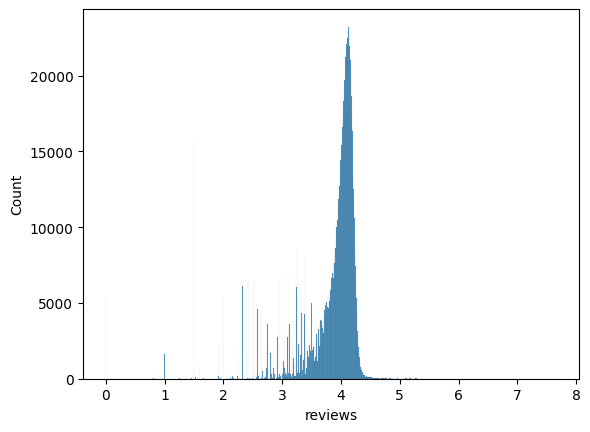

In [20]:
sns.histplot(merged_df['reviews'].apply(calculate_entropy))

In [21]:
'''
def plot_entropy_distribution(test_df, review_col='reviews', 
                             base_entropy_english=4.5, entropy_scale=0.5,
                             max_entropy_chinese=7.5, max_entropy_other=5.5):
    df = test_df.copy()

    
    # Calculate entropies and lengths
    df['entropy'] = df[review_col].apply(calculate_entropy)
    df['length'] = df[review_col].apply(lambda x: len(str(x)))
    
    # Separate by language for analysis
    df['is_chinese'] = df[review_col].apply(lambda x: any('\u4e00' <= c <= '\u9fff' for c in str(x)))
    df['is_cyrillic'] = df[review_col].apply(lambda x: any('\u0400' <= c <= '\u04ff' for c in str(x)))
    
    # Compute dynamic English threshold for mean length (for reference)
    mean_length = df['length'].mean()
    max_entropy_english_mean = base_entropy_english + (mean_length / 100) * entropy_scale
    
    # Stats
    print("Entropy Statistics:")
    print(df['entropy'].describe())
    print(f"\nMean Review Length: {mean_length:.0f} characters")
    print(f"Scaled max_entropy_english at mean length: {max_entropy_english_mean:.2f}")
    
    # Plot histogram
    plt.figure(figsize=(12, 6))
    sns.histplot(df['entropy'], bins=50, color='blue', label='Entropy Distribution')
    
    # Add threshold lines
    plt.axvline(x=base_entropy_english, color='red', linestyle='--', 
                label=f'Base English Threshold ({base_entropy_english})')
    plt.axvline(x=max_entropy_english_mean, color='orange', linestyle='--', 
                label=f'Scaled English at Mean Length ({max_entropy_english_mean:.2f})')
    plt.axvline(x=max_entropy_other, color='green', linestyle='--', 
                label=f'Cyrillic/Other Threshold ({max_entropy_other})')
    plt.axvline(x=max_entropy_chinese, color='purple', linestyle='--', 
                label=f'Chinese Threshold ({max_entropy_chinese})')
    
    # Customize plot
    plt.title('Distribution of Review Entropies')
    plt.xlabel('Entropy')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('review_entropy_dist.png')
    plt.show()
    
    # Optional: Separate by language
    plt.figure(figsize=(12, 6))
    sns.histplot(df[df['is_chinese']]['entropy'], bins=30, kde=True, color='purple', label='Chinese')
    sns.histplot(df[df['is_cyrillic']]['entropy'], bins=30, kde=True, color='green', label='Cyrillic')
    sns.histplot(df[~df['is_chinese'] & ~df['is_cyrillic']]['entropy'], bins=30, 
                 color='blue', label='English/Other')
    plt.title('Entropy Distribution by Language')
    plt.xlabel('Entropy')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('review_entropy_lang.png')
    plt.show()


plot_entropy_distribution(merged_df.copy())
'''

'\ndef plot_entropy_distribution(test_df, review_col=\'reviews\', \n                             base_entropy_english=4.5, entropy_scale=0.5,\n                             max_entropy_chinese=7.5, max_entropy_other=5.5):\n    df = test_df.copy()\n\n    \n    # Calculate entropies and lengths\n    df[\'entropy\'] = df[review_col].apply(calculate_entropy)\n    df[\'length\'] = df[review_col].apply(lambda x: len(str(x)))\n    \n    # Separate by language for analysis\n    df[\'is_chinese\'] = df[review_col].apply(lambda x: any(\'一\' <= c <= \'\u9fff\' for c in str(x)))\n    df[\'is_cyrillic\'] = df[review_col].apply(lambda x: any(\'Ѐ\' <= c <= \'ӿ\' for c in str(x)))\n    \n    # Compute dynamic English threshold for mean length (for reference)\n    mean_length = df[\'length\'].mean()\n    max_entropy_english_mean = base_entropy_english + (mean_length / 100) * entropy_scale\n    \n    # Stats\n    print("Entropy Statistics:")\n    print(df[\'entropy\'].describe())\n    print(f"\nMean Revi

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
import math

def plot_entropy_distribution_by_language(test_df, review_col='reviews', 
                                          base_entropy_english=4.5, entropy_scale=0.5,
                                          max_entropy_chinese=7.5, max_entropy_other=5.5):
    df = test_df.copy()

    # Calculate entropy and review lengths
    df['entropy'] = df[review_col].apply(calculate_entropy)
    df['length'] = df[review_col].apply(lambda x: len(str(x)))
    
    # Identify scripts
    df['is_chinese'] = df[review_col].apply(lambda x: any('\u4e00' <= c <= '\u9fff' for c in str(x)))
    df['is_cyrillic'] = df[review_col].apply(lambda x: any('\u0400' <= c <= '\u04ff' for c in str(x)))
    
    df['language'] = 'English/Other'
    df.loc[df['is_chinese'], 'language'] = 'Chinese'
    df.loc[df['is_cyrillic'], 'language'] = 'Cyrillic'

    mean_length = df['length'].mean()
    max_entropy_english_mean = base_entropy_english + (mean_length / 100) * entropy_scale

    # Stats
    print("Entropy Statistics:")
    print(df.groupby('language')['entropy'].describe())
    print(f"\nMean Review Length: {mean_length:.0f} characters")
    print(f"Scaled max_entropy_english at mean length: {max_entropy_english_mean:.2f}")

    # Plot setup
    language_categories = ['English/Other', 'Chinese', 'Cyrillic']
    colors = {'English/Other': 'blue', 'Chinese': 'purple', 'Cyrillic': 'green'}
    thresholds = {
        'English/Other': [base_entropy_english, max_entropy_english_mean],
        'Chinese': [max_entropy_chinese],
        'Cyrillic': [max_entropy_other]
    }

    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

    for i, lang in enumerate(language_categories):
        subset = df[df['language'] == lang]
        ax = axes[i]
        sns.histplot(subset['entropy'], bins=30, kde=True, ax=ax, color=colors[lang])
        ax.set_title(f'{lang} Entropy Distribution')
        ax.set_xlabel('Entropy')
        ax.set_ylabel('Frequency')
        ax.grid(True, alpha=0.3)

        # Add vertical threshold lines
        for t in thresholds[lang]:
            ax.axvline(x=t, linestyle='--', color='red')

    plt.tight_layout()
    plt.savefig('entropy_by_language.png')
    plt.show()


In [23]:
def is_meaningful_review_multilingual(text, min_alpha_ratio=0.2, 
                                    max_entropy_english=4.5, 
                                    max_entropy_chinese=7.5, 
                                    max_entropy_other=5.5):
    # Get rid of empty reviews
    if not text or pd.isna(text):
        return False
    
    text = str(text).lower()

    # Count Unicode letters for alpha ratio
    alpha_chars = sum(unicodedata.category(c).startswith('L') for c in text)
    total_chars = len(text.replace(" ", ""))
    
    if total_chars == 0 or alpha_chars / total_chars < min_alpha_ratio:
        return False
        
    entropy = calculate_entropy(text)
    
    # Chinese reviews
    if has_chinese(text):
        return total_chars >= 5 and entropy <= max_entropy_chinese
    
    # Cyrillic (e.g., Russian) reviews
    if has_cyrillic(text):
        return total_chars >= 5 and entropy <= max_entropy_other
    
    # English or mixed reviews
    if entropy > max_entropy_english:
        return False
    
    # Make sure entropy is smaller than max_entropy param
    entropy = calculate_entropy(text)
    if entropy > max_entropy_english:  # High entropy indicates randomness
        return 0
    
    # Make sure there is at least one real word in each entry (this will take a long time)
    #word_list = set(words.words())  # NLTK's English word list
    #tokens = re.findall(r'\b[a-z]+\b', text)  # return list of real words in review entry
    #if not tokens:  # No words found
    #    return 0
    
    #dict_words = sum(1 for token in tokens if token in word_list)
    #dict_ratio = dict_words / len(tokens)
    #if dict_ratio < min_dict_ratio:
    #    return 0
    
    return 1

def flag_meaningless_reviews(test_df, review_col='reviews'):
    """Apply the meaningfulness check to a dataframe column and add a flag."""
    df = test_df.copy()
    df['is_meaningful'] = df[review_col].apply(is_meaningful_review_multilingual)
    return df

# DF with column for meaningless/meaningful tag
result_df = flag_meaningless_reviews(merged_df.copy())

# DF filtered for only tag 1
meaningful_df = result_df[result_df['is_meaningful'] == 1].copy()

# Summary of meaningful vs. meaningless
print("\nSummary:")
print(result_df['is_meaningful'].value_counts())



Summary:
is_meaningful
1        1451363
False       3348
Name: count, dtype: int64


What do some of the meaningless phrases look like? We see below that the alphabetic ratio and entropy are hyperparameters that need tuning. Some legitimate cases of "meaningless" are:
1. The entry "NaN'
2. A single punctuation mark or typed out emoji

**NEED TO ADDRESS**
- Right now, it's detecting chinese characters as "meaningless" so wee nee to address this.

In [24]:
print(result_df[result_df['is_meaningful'] == False].sample(5).reviews.values)

['I think this course is a very good introduction and I can not wait to see what the rest of this specialization is like! I wrote a detailed review here at https://medium.com/@masseybr/duke-university-programming-foundations-with-javascript-html-and-css-course-review-4ecd1677fbf7.'
 ':)' '😘😘😘' '..' '5*']


Below is an example of a substantive review written in chinese characters that has a higher entropy than it would in english.

In [25]:
chinese_string = '这是第一门自己申请助学金的课程，而霍普金斯大学也是我非常敬仰的学校，然而这门课程却不如我预想中的完美，第一是视频上来看，图形资源比较匮乏，多媒体资源没有很好的和讲课内容匹配，比如课程音频说的here 在屏幕上并没有显示出来具体的指示标识；第二是相关的资源太少了，如果相比莱顿大学的腹部解剖那门课程来说的确是比较枯燥。不过因为自己本身是这个专业的所以看起来障碍不是太大，不过对于没有肿瘤学基础的人来说上面的问题可能影响会比较大一些，希望团队能在这一方面继续改进。最后还是要感谢各位老师带来这么一门优秀的课程，我从中学到了很多！再次感谢'
alphs = sum(unicodedata.category(c).startswith('L') for c in chinese_string)
total = len(chinese_string.replace(" ", ""))
entropy = calculate_entropy(chinese_string)
print(f'Sum of chars = {alphs}')
print(f"Total Chars = {total}")
print(f"Ratio = {alphs/total}")
print(f"Entropy = {entropy}")

Sum of chars = 251
Total Chars = 265
Ratio = 0.9471698113207547
Entropy = 6.875426197843062


In [26]:
# Below is the english translation of the above chinese text
translated_string = "This is the first course for which I applied for a scholarship myself, and Johns Hopkins University is a school that I admire very much. However, this course is not as perfect as I expected. First, judging from the video, the graphic resources are relatively scarce, and the multimedia resources do not match the lecture content very well. For example, the course audio says here but there is no specific indicator on the screen; second, there are too few related resources. Compared with the abdominal anatomy course at Leiden University, it is indeed quite boring. However, since I am a major in this field, the obstacles do not seem to be too big. However, for those who do not have a foundation in oncology, the above problems may have a greater impact. I hope the team can continue to improve in this regard. Finally, I would like to thank all the teachers for bringing such an excellent course. I have learned a lot from it! Thanks again"
alphs = sum(unicodedata.category(c).startswith('L') for c in translated_string)
total = len(translated_string.replace(" ", ""))
entropy = calculate_entropy(translated_string)
print(f'Sum of chars = {alphs}')
print(f"Total Chars = {total}")
print(f"Ratio = {alphs/total}")
print(f"Entropy = {entropy}")

Sum of chars = 753
Total Chars = 777
Ratio = 0.9691119691119691
Entropy = 4.189814493527101


#### Distribution of Reviews by Language
- Here we check to see how many reviews are in different languages. Let's investigate if there is a statistically significant difference in average entropy between different langugages' reviews
- **NOTE:** Tagging the language of the DF takes ~2 hours on the Kaggle CPU

Detecting Languages: 100%|██████████| 1454711/1454711 [1:44:21<00:00, 232.32it/s]


Language Distribution:
|    | language   |   count |
|---:|:-----------|--------:|
|  0 | en         | 1190431 |
|  1 | es         |   98409 |
|  2 | fr         |   32954 |
|  3 | so         |   19871 |
|  4 | ro         |   15920 |
|  5 | pt         |   15672 |
|  6 | ca         |   15586 |
|  7 | af         |   12660 |
|  8 | unknown    |    7202 |
|  9 | ru         |    6330 |
| 10 | de         |    6301 |
| 11 | it         |    4216 |
| 12 | no         |    3651 |
| 13 | zh-cn      |    3250 |
| 14 | pl         |    3184 |
| 15 | tl         |    2172 |
| 16 | sw         |    2038 |
| 17 | cy         |    2019 |
| 18 | id         |    1490 |
| 19 | nl         |    1480 |
| 20 | da         |    1394 |
| 21 | vi         |    1351 |
| 22 | sl         |    1108 |
| 23 | ko         |     948 |
| 24 | cs         |     734 |
| 25 | et         |     538 |
| 26 | ar         |     491 |
| 27 | tr         |     443 |
| 28 | sq         |     418 |
| 29 | fi         |     408 |
| 30 | sv        

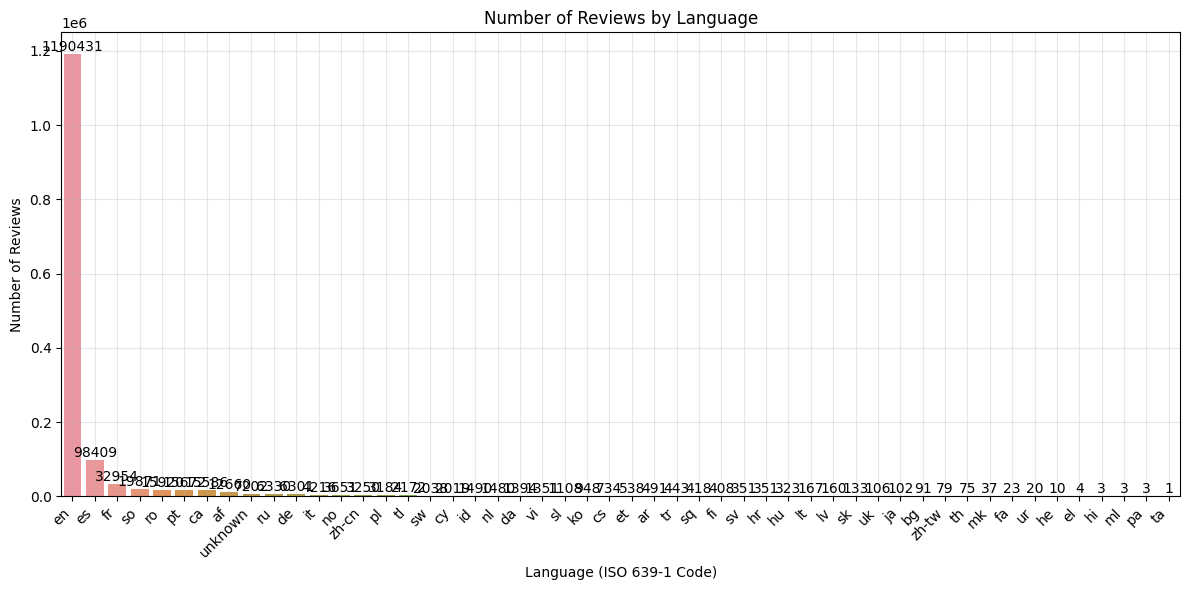

In [27]:
from langdetect import detect
import warnings

# Suppress langdetect warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)

def detect_language(text):

    if not isinstance(text, str) or pd.isna(text) or len(text.strip()) < 3:
        return 'unknown'  # For NaN, empty, or very short text
    try:
        return detect(text)
    except:
        return 'unknown'  # Fallback for any detection errors

# Get distribution of langugages using langdetect
def plot_language_distribution(df, review_col='reviews'):

    # Detect language for each review
    tqdm.pandas(desc="Detecting Languages") 
    df['language'] = df[review_col].progress_apply(detect_language)
    # Save this df with tagged languages to file
    df.to_pickle('merged_df_w_langs.pkl')
    # Count reviews per language
    language_counts = df['language'].value_counts().reset_index()
    language_counts.columns = ['language', 'count']
    
    # Print stats
    print("Language Distribution:")
    print(language_counts.to_markdown())
    
    # Plot bar chart
    plt.figure(figsize=(12, 6))
    sns.barplot(data=language_counts, x='language', y='count')
    plt.title('Number of Reviews by Language')
    plt.xlabel('Language (ISO 639-1 Code)')
    plt.ylabel('Number of Reviews')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    
    # Add count labels on top of bars
    for i, row in language_counts.iterrows():
        plt.text(i, row['count'], row['count'], ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('num_reviews_language.png')
    plt.show()
    return df # Return back the original df WITH a new language column

# Install langdetect if needed: pip install langdetect
lang_df = plot_language_distribution(merged_df.copy())

#### Reviews per Course
- Are there courses with very few or a ton of course reviews?

In [28]:
# Number of reviews per course
reviews_per_course = df.groupby('course_id').size()
print("Reviews per Course Stats:")
print(f'| Stat | Value |')
print(reviews_per_course.describe().to_markdown())
print(f'| median | {reviews_per_course.median()} |')

Reviews per Course Stats:
| Stat | Value |
|       |        0 |
|:------|---------:|
| count |   604    |
| mean  |  2408.21 |
| std   |  4599.04 |
| min   |     3    |
| 25%   |   374.25 |
| 50%   |  1071.5  |
| 75%   |  2408.25 |
| max   | 45218    |
| median | 1071.5 |


Reviews per Course Stats:
| Stat | Value |
|:------|---------:|
| count |   604    |
| mean  |  2408.21 |
| std   |  4599.04 |
| min   |     3    |
| 25%   |   374.25 |
| 50%   |  1071.5  |
| 75%   |  2408.25 |
| max   | 45218    |
| median | 1071.5 |

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


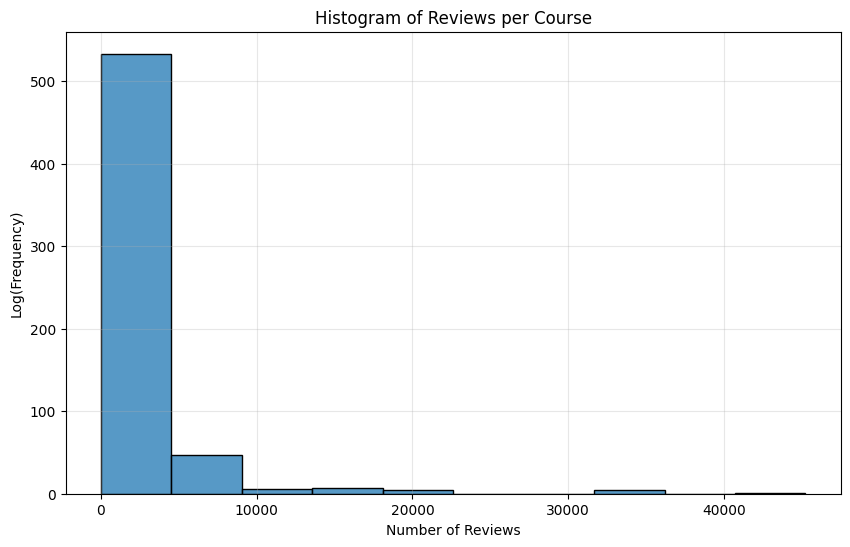

In [29]:
# Rebin the course review data to 1-10, 10-100, 100+
plt.figure(figsize=(10, 6))
sns.histplot(reviews_per_course, bins=10)
plt.title('Histogram of Reviews per Course')
plt.xlabel('Number of Reviews')
plt.ylabel('Log(Frequency)')
plt.grid(True, alpha=0.3)
#plt.xscale('log')
#plt.yscale('log')
plt.show()

Not super meaningful. Let's do the same thing with review count as we did with character count


97.5th Percentile Cutoff: 14295 reviews


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


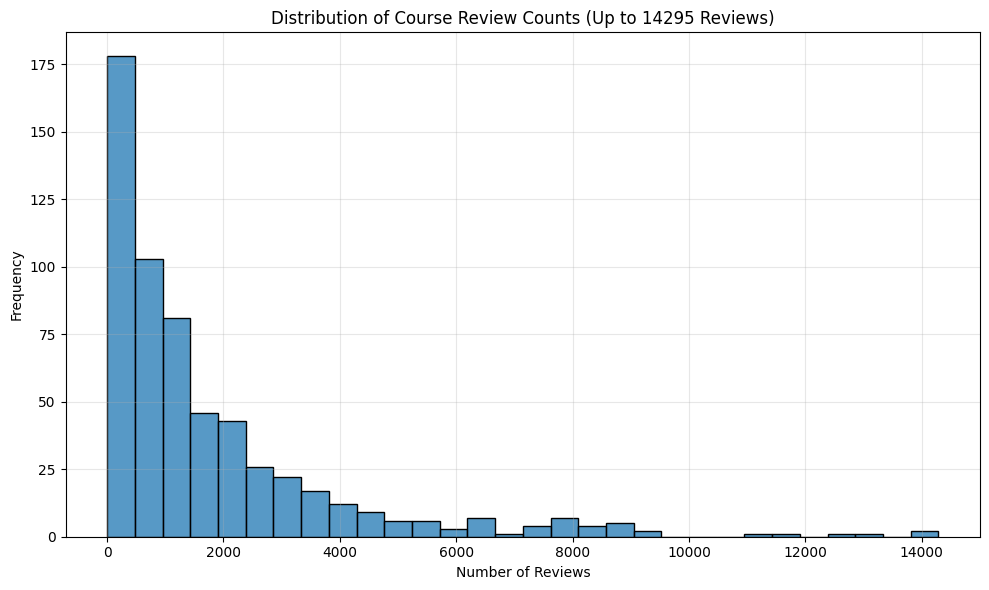


Sample of Outlier Reviews:
| Course ID | Review Count |
|-------------|------------|
| ai-for-everyone | 21624 |
| data-scientists-tools | 17595 |
| deep-neural-network | 17850 |
| excel-essentials | 21248 |
| gcp-fundamentals | 17419 |



In [30]:
def plot_review_count_distribution(original_df, id_col='course_id', percentile_cutoff=95, sample_size=5):

    copy_df = original_df.copy()
    df = copy_df.groupby(id_col).size().reset_index(name='review_count')
    
    # Set review count cutoff to a given percentile for plotting. Defult to 95
    cutoff = np.percentile(df['review_count'], percentile_cutoff)
    print(f"\n{percentile_cutoff}th Percentile Cutoff: {cutoff:.0f} reviews")

    main_range = df['review_count'][df['review_count'] <= cutoff]
    outliers = df[df['review_count'] > cutoff]
    
    # Plot histogram for main range
    plt.figure(figsize=(10, 6))
    sns.histplot(main_range, bins=30)
    plt.title(f'Distribution of Course Review Counts (Up to {cutoff:.0f} Reviews)')
    plt.xlabel('Number of Reviews')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('review_count_hist.png')
    plt.show()

    # Make output df of outliers and print to markdown
    if not outliers.empty:
        
        outlier_sample = outliers[[id_col, 'review_count']].head(sample_size)
        
        md_table = "| Course ID | Review Count |\n"
        md_table += "|-------------|------------|\n"
        for _, row in outlier_sample.iterrows():
            # Truncate long text for display (optional)
            text = row[id_col]
            md_table += f"| {text} | {row['review_count']} |\n"
        
        print("\nSample of Outlier Reviews:")
        print(md_table)


plot_review_count_distribution(df, percentile_cutoff=97.5)

Sample of Outlier Reviews:
| Course ID | Review Count |
|-------------|------------|
| ai-for-everyone | 21624 |
| data-scientists-tools | 17595 |
| deep-neural-network | 17850 |
| excel-essentials | 21248 |
| gcp-fundamentals | 17419 |